In [59]:
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR, LambdaLR, CosineAnnealingLR
from torch.utils.data import DataLoader
from torchviz import make_dot

from swag import SWAG
from models import SimpleNet, ConvNN, Classification_relu, Classification_sigmoid, Classification_tanh
from util import model_param_to_1D, params_1d_to_weights, create_NN_with_weights, plot_decision_boundary
from data_gen import ClassificationDataSet

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Classification on CIFAR10

The paper claims that the test accuracies of SWAG on the several image datasets typically outperforms all the baseline models in terms of accuracy.

In the below section, we will train a model on the dataset CIFAR-10. The CIFAR-10 dataset is a collection of images that are commonly used to train machine learning and computer vision algorithms:
1. It contains 60,000 32x32 color images in 10 different classes. 
2. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. 
3. There are 6000 images of each class.

We split the dataset into training and testing set, where the training set contrains 50000 images and the test set contains 10000 images.

Due to the computational power limit, we are going to train a Simple Convolutional Neural network with the following architecture.

## Model Architechture

In [60]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [61]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Load train-test data

In [62]:
transform_train = transforms.Compose([
    transforms.Resize((40, 40)),       
    transforms.RandomCrop((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=3,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=3,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


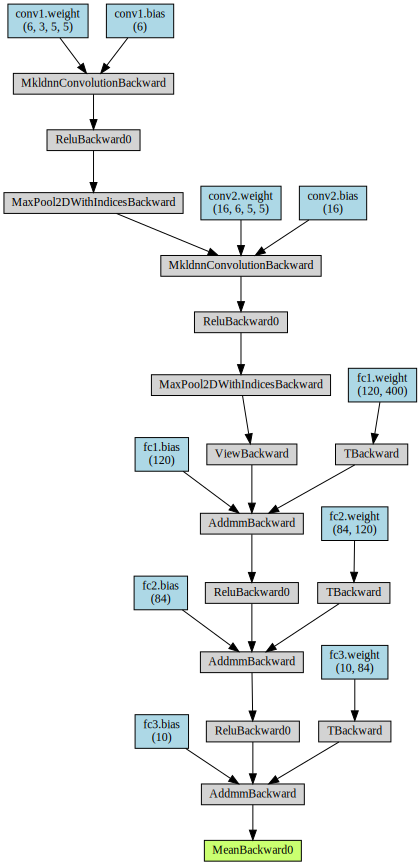

In [63]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
y = net(images)
make_dot(y.mean(),params = dict(net.named_parameters()))

### Loss function and optmizer

In [64]:
# Use the Classification Cross-Entropy loss and Adam optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [65]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(40, 40), interpolation=PIL.Image.BILINEAR)
               RandomCrop(size=(32, 32), padding=None)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-15.0, 15.0], resample=False, expand=False)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([7, 8, 2])
horse  ship  bird


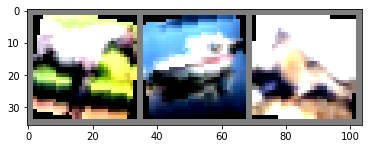

In [66]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# print labels
print(labels)
print(' '.join('%5s' % classes[labels[j]] for j in range(3)))
# show images
imshow(torchvision.utils.make_grid(images))

## Training without SWAG

### Training the model

In [9]:
def data_train(model= net, epoch = 2, model_path = '', optimizer = optimizer, criterion = criterion,trainloader = trainloader,batch = 2000):
    for epoch in range(epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % batch == (batch-1):    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / batch))
                running_loss = 0.0
    print('Finished Training.')
    torch.save(model.state_dict(), model_path)
    print('Saved model parameters to disk.')
    

In [10]:
import os

model_directory_path = '/Users/zhaoliyang/Desktop/AM207/swag_uncertainty/model/'
model_path = model_directory_path + 'cifar-10-cnn-model.pt'

if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)

if os.path.isfile(model_path):
    # load trained model parameters from disk
    net.load_state_dict(torch.load(model_path))
    print('Loaded model parameters from disk.')
else:
    data_train(net,3,model_path)

Loaded model parameters from disk.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


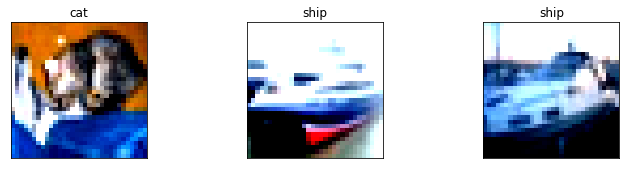

In [11]:
def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)
dataiter = iter(testloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

### Test Accuracy

In [46]:
def test_accuracy(model, testloader = testloader, classes = classes):
    # Overall accuracy on
    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([len(classes),len(classes)], int)
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1 

    model_accuracy = total_correct / total_images * 100
    print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))
    return confusion_matrix

In [13]:
confusion_matrix = test_accuracy(net)

Model accuracy on 10000 test images: 53.07%


In [47]:
def accuracy_class(cm):
    # On different categories
    print('{0:10s} - {1}'.format('Category','Accuracy'))
    for i, r in enumerate(cm):
        print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

In [15]:
accuracy_class(confusion_matrix)

Category   - Accuracy
plane      - 51.1
car        - 76.4
bird       - 27.1
cat        - 37.5
deer       - 41.9
dog        - 27.6
frog       - 75.3
horse      - 63.8
ship       - 70.2
truck      - 59.8


## Swag

In [16]:
swag = SWAG(Net, 3, True, net)

/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


In [17]:
# Compile swa
objective = 'classification'
lr = 1e-3
momentum=0.9
optimizer = optim.SGD
loss_fn = nn.CrossEntropyLoss()
swa_scheduler = LambdaLR

swag.compile(objective, lr,1, momentum, optimizer, loss_fn, swa_scheduler)

In [28]:
# Fit swag
first_mom, second_mom, D = swag.fit(trainloader,
                                    train_epoch=0,
                                    swag_epoch=3,
                                    log_freq=4000,
                                   pretrained = True)

Begin NN model training...

Begin SWAG training...
[Epoch: 1, 	Iteration:  4000] 	Training Loss: 1.4128
[Epoch: 1, 	Iteration:  8000] 	Training Loss: 1.4037
[Epoch: 1, 	Iteration: 12000] 	Training Loss: 1.4100
[Epoch: 1, 	Iteration: 16000] 	Training Loss: 1.4190
[Epoch: 2, 	Iteration:  4000] 	Training Loss: 1.3848
[Epoch: 2, 	Iteration:  8000] 	Training Loss: 1.4046
[Epoch: 2, 	Iteration: 12000] 	Training Loss: 1.3964
[Epoch: 2, 	Iteration: 16000] 	Training Loss: 1.4118
[Epoch: 3, 	Iteration:  4000] 	Training Loss: 1.3951
[Epoch: 3, 	Iteration:  8000] 	Training Loss: 1.3989
[Epoch: 3, 	Iteration: 12000] 	Training Loss: 1.4122
[Epoch: 3, 	Iteration: 16000] 	Training Loss: 1.4001


In [29]:
# Test prediction
testiter = iter(testloader)
X_test, y_test = testiter.next()
params_1d, shape_lookup, len_lookup = model_param_to_1D(net)
model_params = params_1d_to_weights(first_mom, shape_lookup, len_lookup)

In [30]:
new_net = create_NN_with_weights(Net, model_params)

In [32]:
# Overall accuracy
confusion_matrix_swag = test_accuracy(new_net)

Model accuracy on 10000 test images: 54.95%


In [33]:
accuracy_class(confusion_matrix_swag)

Category   - Accuracy
plane      - 49.2
car        - 72.9
bird       - 31.3
cat        - 23.4
deer       - 36.4
dog        - 34.7
frog       - 82.5
horse      - 68.6
ship       - 74.2
truck      - 76.3


From the above results, we trained 3 epochs on our simple CNN models and got overall accuracy of 53.07% on the test set classification task. After that, we used the weights of the trained network as initial value of the SWAG weights and performed swag algorithm for 3 epochs. We see that the accuracy has increased around 2% to 54.95%. Indeed, the SWAG algorithm is capable of outperforming the baseline model in terms of accuracy.

## Uncertainty Measurement

From the above experiment, we verify that SWAG algorithm is capable of outperforming the baseline model in terms of accuracy on a simple neural network model. What's more important is that we want to measure if the SWAG algorithm is able to help the model to detect the out-of-distribution samples. 

We will interpret the output of our Neural Network Model - the classification probability - as an indicator of the confidence of the model when it is classifying a specific data point. Specifically, we will only train the model on 2 categories of the image (e.g. when the probability is close to 0.5, we say that the model is not confident in classifying the data point as class 1 or 0).

After training the model via SWAG algorithm, we are able to draw sets of parameters and form a posterior distribution of the model. As a result, we will apply those models on a predefined set of test images (some of them are OOD samples) and check the classification probability again.

### Write functions to choose only specific classes of CIFAR-10

In [300]:
# Transformations
RC   = transforms.RandomCrop(32, padding=4)
RHF  = transforms.RandomHorizontalFlip()
RVF  = transforms.RandomVerticalFlip()
NRM  = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
TT   = transforms.ToTensor()
TPIL = transforms.ToPILImage()

# Transforms object for trainset with augmentation
transform_with_aug = transforms.Compose([TPIL, RC, RHF, TT, NRM])
# Transforms object for testset with NO augmentation
transform_no_aug   = transforms.Compose([TT, NRM])

# Downloading/Louding CIFAR10 data
trainset  = CIFAR10(root='./data', train=True , download=True)#, transform = transform_with_aug)
testset   = CIFAR10(root='./data', train=False, download=True)#, transform = transform_no_aug)
classDict = {'plane':0, 'car':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}

# Separating trainset/testset data/label
x_train  = trainset.data
x_test   = testset.data
y_train  = trainset.targets
y_test   = testset.targets

# Define a function to separate CIFAR classes by class index

def get_class_i(x, y, i):
    """
    x: trainset.train_data or testset.test_data
    y: trainset.train_labels or testset.test_labels
    i: class label, a number between 0 to 9
    return: x_i
    """
    # Convert to a numpy array
    y = np.array(y)
    # Locate position of labels that equal to i
    pos_i = np.argwhere(y == i)
    # Convert the result into a 1-D list
    pos_i = list(pos_i[:,0])
    # Collect all data that match the desired label
    x_i = [x[j] for j in pos_i]
    
    return x_i

class DatasetMaker(Dataset):
    def __init__(self, datasets, transformFunc = transform_no_aug):
        """
        datasets: a list of get_class_i outputs, i.e. a list of list of images for selected classes
        """
        self.datasets = datasets
        self.lengths  = [len(d) for d in self.datasets]
        self.transformFunc = transformFunc
    def __getitem__(self, i):
        class_label, index_wrt_class = self.index_of_which_bin(self.lengths, i)
        img = self.datasets[class_label][index_wrt_class]
        img = self.transformFunc(img)
        return img, class_label

    def __len__(self):
        return sum(self.lengths)
    
    def index_of_which_bin(self, bin_sizes, absolute_index, verbose=False):
        """
        Given the absolute index, returns which bin it falls in and which element of that bin it corresponds to.
        """
        # Which class/bin does i fall into?
        accum = np.add.accumulate(bin_sizes)
        if verbose:
            print("accum =", accum)
        bin_index  = len(np.argwhere(accum <= absolute_index))
        if verbose:
            print("class_label =", bin_index)
        # Which element of the fallent class/bin does i correspond to?
        index_wrt_class = absolute_index - np.insert(accum, 0, 0)[bin_index]
        if verbose:
            print("index_wrt_class =", index_wrt_class)

        return bin_index, index_wrt_class

Files already downloaded and verified
Files already downloaded and verified


In [301]:
# Choose only cats (class 3 of CIFAR) and dogs (class 5 of CIFAR) as trainset/testset
cat_dog_trainset = \
    DatasetMaker(
        [get_class_i(x_train, y_train, classDict['cat']), get_class_i(x_train, y_train, classDict['dog'])],
        transform_with_aug
    )
cat_dog_testset  = \
    DatasetMaker(
        [get_class_i(x_test , y_test , classDict['cat']), get_class_i(x_test , y_test , classDict['dog'])],
        transform_no_aug
    )

kwargs = {'num_workers': 2, 'pin_memory': False}

# Create datasetLoaders from trainset and testset
trainsetLoader   = DataLoader(cat_dog_trainset, batch_size=4, shuffle=True , **kwargs)
testsetLoader    = DataLoader(cat_dog_testset , batch_size=4, shuffle=False, **kwargs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 1, 1, 1])
  Dog   Dog   Dog   Dog


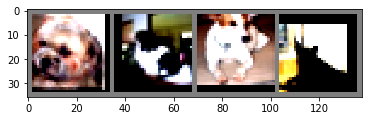

In [125]:
classes = ['Cat','Dog']
# get some random training images
dataiter = iter(trainsetLoader)
images, labels = dataiter.next()

# print labels
print(labels)
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# show images
imshow(torchvision.utils.make_grid(images))

### Train the Model

### Model Architecture

In [141]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3,   64,  3)
        self.conv2 = nn.Conv2d(64,  128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

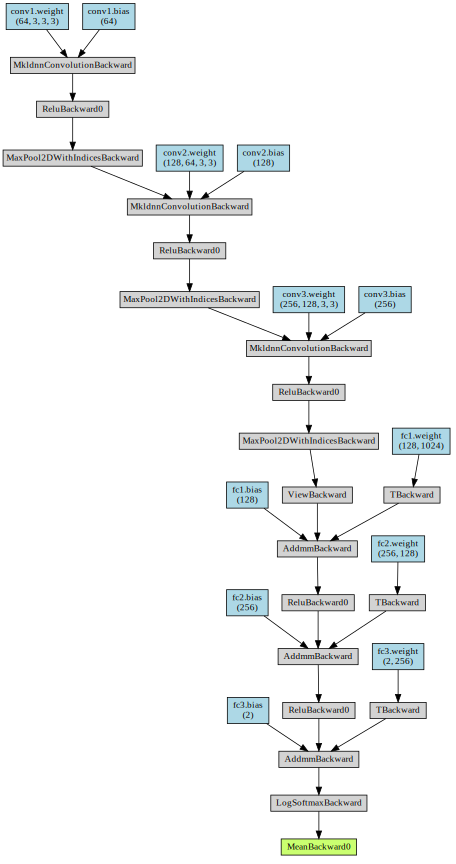

In [142]:
dataiter = iter(trainsetLoader)
images, labels = dataiter.next()
y = nnt(images)
make_dot(y.mean(),params = dict(nnt.named_parameters()))

### Define Training Procedure

In [131]:
def train(model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx > 0 and batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{}\t({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

In [132]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (float(correct) / len(test_loader.dataset))

### Train the model

In [133]:
model = CNN()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cpu") 
losses = []
accuracies = []
for epoch in range(0, 20):
    losses.extend(train(model, device, trainsetLoader, optimizer, epoch))
    accuracies.append(test(model, device, trainsetLoader))

Train Epoch: 0 [4000/10000	(40%)]	Loss: 0.712870
Train Epoch: 0 [8000/10000	(80%)]	Loss: 0.748642

Average loss: 0.6741, Accuracy: 5792/10000 (58%)

Train Epoch: 1 [4000/10000	(40%)]	Loss: 0.669302
Train Epoch: 1 [8000/10000	(80%)]	Loss: 0.559815

Average loss: 0.6522, Accuracy: 6158/10000 (62%)

Train Epoch: 2 [4000/10000	(40%)]	Loss: 0.390478
Train Epoch: 2 [8000/10000	(80%)]	Loss: 1.092763

Average loss: 0.6156, Accuracy: 6541/10000 (65%)

Train Epoch: 3 [4000/10000	(40%)]	Loss: 0.544521
Train Epoch: 3 [8000/10000	(80%)]	Loss: 0.431222

Average loss: 0.5757, Accuracy: 6903/10000 (69%)

Train Epoch: 4 [4000/10000	(40%)]	Loss: 1.083134
Train Epoch: 4 [8000/10000	(80%)]	Loss: 0.713752

Average loss: 0.5332, Accuracy: 7321/10000 (73%)

Train Epoch: 5 [4000/10000	(40%)]	Loss: 0.389645
Train Epoch: 5 [8000/10000	(80%)]	Loss: 0.960606

Average loss: 0.5279, Accuracy: 7321/10000 (73%)

Train Epoch: 6 [4000/10000	(40%)]	Loss: 0.421296
Train Epoch: 6 [8000/10000	(80%)]	Loss: 0.280745

Average

### Save weights

In [138]:
model_directory_path = '/Users/zhaoliyang/Desktop/AM207/swag_uncertainty/model/'
model_path = model_directory_path + 'cifar-10-cnn-catdog2-model.pt'
if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)
torch.save(model.state_dict(), model_path)

### Check accuracy on test set

In [139]:
confusion_matrix_catdog = test_accuracy(model,testsetLoader,classes)

Model accuracy on 2000 test images: 84.45%


In [140]:
accuracy_class(confusion_matrix_catdog)

Category   - Accuracy
Cat        - 87.2
Dog        - 81.7


## SWAG

We've achieved a 84.45% accuracy on the test set classification, next we will apply the SWAG algorithm based on the above model

In [252]:
swag = SWAG(CNN, 5, True, model)

In [253]:
# Compile swa
objective = 'classification'
lr = 1e-3
momentum=0.9
optimizer = optim.SGD
loss_fn = nn.CrossEntropyLoss()
swa_scheduler = LambdaLR

swag.compile(objective, lr,1, momentum, optimizer, loss_fn, swa_scheduler)

In [254]:
# Fit swag
first_mom, second_mom, D = swag.fit(trainsetLoader,
                                    train_epoch=0,
                                    swag_epoch=5,
                                    log_freq=500,
                                   pretrained = True)

Begin NN model training...

Begin SWAG training...
[Epoch: 1, 	Iteration:   500] 	Training Loss: 0.3028
[Epoch: 1, 	Iteration:  1000] 	Training Loss: 0.3087
[Epoch: 1, 	Iteration:  1500] 	Training Loss: 0.3073
[Epoch: 1, 	Iteration:  2000] 	Training Loss: 0.3061
[Epoch: 1, 	Iteration:  2500] 	Training Loss: 0.3303
[Epoch: 2, 	Iteration:   500] 	Training Loss: 0.2698
[Epoch: 2, 	Iteration:  1000] 	Training Loss: 0.2901
[Epoch: 2, 	Iteration:  1500] 	Training Loss: 0.3100
[Epoch: 2, 	Iteration:  2000] 	Training Loss: 0.3114
[Epoch: 2, 	Iteration:  2500] 	Training Loss: 0.3095
[Epoch: 3, 	Iteration:   500] 	Training Loss: 0.3038
[Epoch: 3, 	Iteration:  1000] 	Training Loss: 0.2938
[Epoch: 3, 	Iteration:  1500] 	Training Loss: 0.3082
[Epoch: 3, 	Iteration:  2000] 	Training Loss: 0.2998
[Epoch: 3, 	Iteration:  2500] 	Training Loss: 0.3221
[Epoch: 4, 	Iteration:   500] 	Training Loss: 0.2772
[Epoch: 4, 	Iteration:  1000] 	Training Loss: 0.3003
[Epoch: 4, 	Iteration:  1500] 	Training Loss: 0.

In [262]:
# Test prediction
testiter = iter(testsetLoader)
X_test, y_test = testiter.next()
params_1d, shape_lookup, len_lookup = model_param_to_1D(model)
model_params = params_1d_to_weights(first_mom, shape_lookup, len_lookup)

In [263]:
model_swag = create_NN_with_weights(CNN, model_params)

In [302]:
classes = ['Cat','Dog']
confusion_matrix_catdog_swag = test_accuracy(model_swag,testsetLoader,classes)

Model accuracy on 2000 test images: 86.85%


In [303]:
accuracy_class(confusion_matrix_catdog_swag)

Category   - Accuracy
Cat        - 86.7
Dog        - 87.0


### Choose samples to predict

In [290]:
# Choose only cats (class 3 of CIFAR) and dogs (class 5 of CIFAR) as trainset/testset
cat_dog_horse_trainset = \
    DatasetMaker(
        [get_class_i(x_train, y_train, classDict['cat']), get_class_i(x_train, y_train, classDict['dog']),
        get_class_i(x_train, y_train, classDict['horse'])],
        transform_with_aug
    )
cat_dog_horse_testset  = \
    DatasetMaker(
        [get_class_i(x_test , y_test , classDict['cat']), get_class_i(x_test , y_test , classDict['dog']),
        get_class_i(x_train, y_train, classDict['horse'])],
        transform_no_aug
    )

kwargs = {'num_workers': 2, 'pin_memory': False}

# Create datasetLoaders from trainset and testset
trainsetLoader   = DataLoader(cat_dog_horse_trainset, batch_size=10, shuffle=True , **kwargs)
testsetLoader    = DataLoader(cat_dog_horse_testset , batch_size=10, shuffle=False, **kwargs)

In [291]:
classes = ['Cat','Dog','Horse']
# get some random images
dataiter = iter(testsetLoader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
Horse Horse Horse Horse


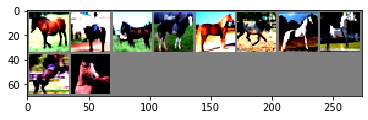

In [292]:
images, labels = dataiter.next()

# print labels
print(labels)
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# show images
imshow(torchvision.utils.make_grid(images))

In [296]:
outputs = model_swag(images)
sm = torch.nn.Softmax()
probabilities = sm(outputs) 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


In [297]:
probabilities

tensor([[0.0181, 0.9819],
        [0.8741, 0.1259],
        [0.4754, 0.5246],
        [0.0311, 0.9689],
        [0.4021, 0.5979],
        [0.5093, 0.4907],
        [0.4328, 0.5672],
        [0.8588, 0.1412],
        [0.4360, 0.5640],
        [0.4563, 0.5437]], grad_fn=<SoftmaxBackward>)

## SWAG Uncertainty 

We will first fixed a test that contains both in-distribution samples and out-of-distribution samples. We will select 5 images from all different classes.

In [374]:
# Fixed a test
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
images_ls = {}
label_ls = {}
for i in classes:
    testset  = \
        DatasetMaker(
            [get_class_i(x_test , y_test , classDict[i])],
            transform_no_aug
        )

    kwargs = {'num_workers': 2, 'pin_memory': False}

    # Create datasetLoaders from trainset and testset
    testsetLoader    = DataLoader(testset , batch_size=5, shuffle=True, **kwargs)
    dataiter = iter(testsetLoader)
    images, labels = dataiter.next()
    images_ls[i] = images
    label_ls[i] = labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


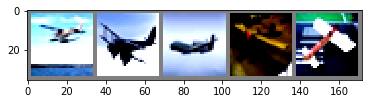

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


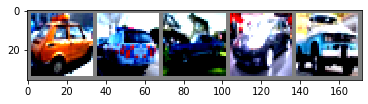

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


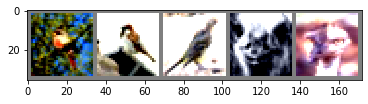

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


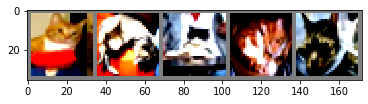

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


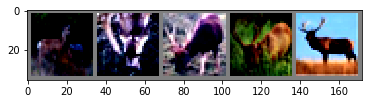

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


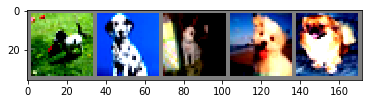

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


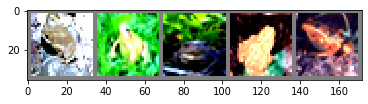

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


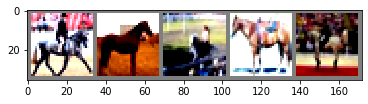

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


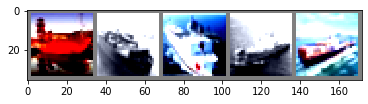

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


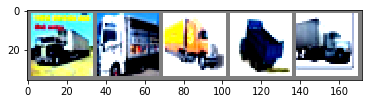

In [379]:
for i in classes:
    imshow(torchvision.utils.make_grid(images_ls[i]))

### Sample from SWAG Posterior Distribution

In [375]:
# Generate weight samples
S = 1000
weight_samples = []
for i in range(S):
    samples = swag.weight_sampler()
    weight_samples.append(samples)

# Recreate Models:
swag_models = []
for s, weight_param in enumerate(weight_samples):
    model_params = params_1d_to_weights(weight_param, swag.shape_lookup, swag.len_lookup)
    new_net = create_NN_with_weights(swag.NN_class, model_params)
    swag_models.append(new_net)

In [376]:
Prediction_var = {}
sm = torch.nn.Softmax()
for i in classes:
    data = images_ls[i]
    prediction_ls = []
    for j in swag_models:
        outputs=j(data)
        prob = sm(outputs) 
        Prediction = np.argmax(prob.detach().numpy(),axis = 1)
        prediction_ls.append(Prediction)
    Prediction_var[i] = np.var(prediction_ls,axis = 0)
        

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


In [377]:
Epistemic_df = pd.DataFrame.from_dict(Prediction_var)

In [378]:
np.mean(Epistemic_df)

plane    0.127743
car      0.133941
bird     0.174468
cat      0.134591
deer     0.159312
dog      0.091142
frog     0.159871
horse    0.150899
ship     0.092147
truck    0.159165
dtype: float64